<a href="https://colab.research.google.com/github/villagab4/Semi-Supervised-Learning/blob/master/Data_Science_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Final 
## Semi-Supervised Learning
### Gabe Villasana and Andrew Rojas


## Model

In [ ]:
import sklearn
import scipy.spatial.distance
import scipy
import numpy as np
import time
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

In [ ]:
def get_adjacency_graph(X, k=10, weight='simple', t=2):
    dists = scipy.spatial.distance.cdist(X, X, metric='euclidean')
    knns = np.zeros(shape=dists.shape)
    for i in range(dists.shape[0]):
        temp = np.argsort(dists[i])[1:k + 1]
        if weight == 'simple':
          knns[i, temp] = 1
        elif weight == 'heat':
          for j in temp:
            knns[i][j] = np.exp(-(dists[i][j])/t)
    adjacency = np.logical_or(knns.T, knns).astype(int)
    return adjacency

In [ ]:
def eigenfunctions(adj, p=4):
    d = np.sum(adj, axis=0)
    d = np.diag(d)
    l = d - adj
    eig_vals, eig_vecs = eigs(l.astype(float), k=p, which='SM')
    smallest_eigs = np.argsort(eig_vals)
    smallest_vecs = eig_vecs[:,smallest_eigs]
    return smallest_vecs

In [ ]:
def build_classifier(vecs, labeled_x, labels, num_classes, p=4):
    num_labeled = labeled_x.shape[0]
    A = np.zeros(shape=(num_classes, p))
    for i in range(num_classes):
        is_label = (labels == i).astype(int).reshape(num_labeled,1)
        is_label[is_label == 0] = -1
        E = vecs[:num_labeled, :]
        A[i,:] = np.squeeze(np.matmul(np.matmul(np.linalg.inv(np.matmul(E.T, E)), E.T), is_label))
    return A

In [ ]:
def label_data(A, vecs, s):
    scores = np.matmul(A, vecs[s:, :].T)
    return np.argmax(scores, axis=0)

In [ ]:
def plot_error(error_rates, title):
    plt.figure()
    plt.plot(error_rates)
    plt.title(title)

## Importing Data

In [ ]:
from sklearn.datasets import fetch_openml, fetch_olivetti_faces
from sklearn.utils import shuffle
# Load data from https://www.openml.org/d/554
MNIST_X, MNIST_Labels = fetch_openml('mnist_784', version=1, return_X_y=True)
MNIST_X, MNIST_Labels = shuffle(MNIST_X, MNIST_Labels)
FacesX, FacesLabels = fetch_olivetti_faces(return_X_y = True, shuffle = True)

## MNIST Experiment

For the MNIST experiment, there are 10 classes, one for each possible digit of the dataset. The dataset contains 60000 labeled examples. Each example in the dataset is a $28*28=784$ dimensional image. In order to test our semi-supervised methods, we used 1000 labeled data points and attempted to classify 9000 unlabeled data points correctly. Our hyperparameters include the $k$ used for nearest neighbors and the $p$ for the number of eigenfunctions to populate our laplacian eigenmap. The paper which outlines the above algorithm chose $k = 8$ and we ran our own experiments to determine an appropriate value for $p$.  

In [ ]:
num_labeled = 1000
num_classes = 10
total_samples = 10000
k = 8
labeled_MNIST_X = MNIST_X[:num_labeled]
labeled_MNIST_y = MNIST_Labels[:num_labeled].astype(int)
unlabeled_MNIST_X = MNIST_X[num_labeled:total_samples] # not used
real_labels_MNIST = MNIST_Labels[num_labeled:total_samples].astype(int)

In [ ]:
MNIST_X.shape

(70000, 784)

### MNIST Examples

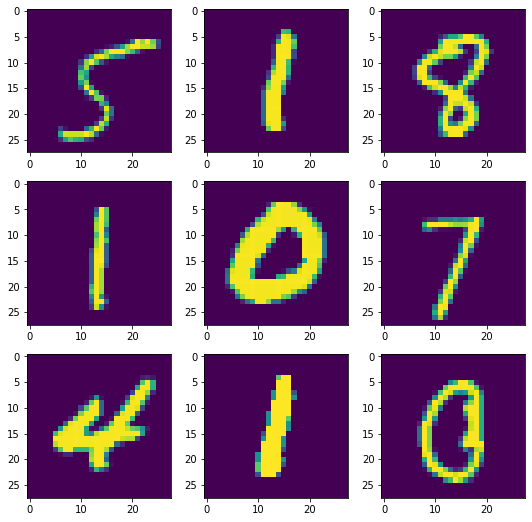

In [ ]:
import random
from google.colab import files
ax = []
fig = plt.figure(figsize=(9,9))
sample = random.randint(0, 390)
j = 0
for i in range(sample, sample + 9):
    img = MNIST_X[i].reshape(28,28)
    ax.append(fig.add_subplot(3,3,j+1))
    plt.imshow(img)
    j += 1
k =plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


p=50, error_rate=0.07088888888888889
p=100, error_rate=0.06566666666666666
p=150, error_rate=0.065
p=200, error_rate=0.06577777777777778
p=250, error_rate=0.066
p=300, error_rate=0.07166666666666667
p=350, error_rate=0.077
p=400, error_rate=0.082
Best performing p value: 133 with error rate of 6.377777777777778


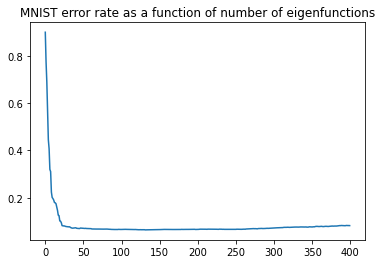

In [ ]:
k = 8

largest_p_value = 50

error_rates = []
# Build adjacency graph for the data using all available samples
adj = get_adjacency_graph(MNIST_X[:total_samples], k)
# Solve for all possible eigenvectors 
vecs = eigenfunctions(adj, largest_p_value)
# Iterate through possible choices of p and select best performing
for p in range(1, largest_p_value + 1):
    A = build_classifier(vecs[:, :p], labeled_MNIST_X, labeled_MNIST_y, num_classes, p)
    prediction = label_data(A, vecs[:, :p], num_labeled)
    error_rate = np.sum(prediction != real_labels_MNIST) / prediction.shape[0]
    error_rates.append(error_rate)
    if (p % 50 == 0):
        print(f'p={p}, error_rate={error_rate}')

plot_error(error_rates, 'MNIST error rate as a function of number of eigenfunctions')

best_p = np.argmin(error_rates) + 1
best_error_rate = np.min(error_rates)
print(f'Best performing p value: {best_p} with error rate of {best_error_rate * 100}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


k=2, error_rate=0.1348888888888889
k=5, error_rate=0.075
k=8, error_rate=0.08044444444444444
k=11, error_rate=0.08322222222222223
k=14, error_rate=0.08288888888888889
k=17, error_rate=0.08544444444444445
k=20, error_rate=0.089
k=23, error_rate=0.09266666666666666
k=26, error_rate=0.09333333333333334
k=29, error_rate=0.096
Best performing k value: 2 with error rate of 7.5


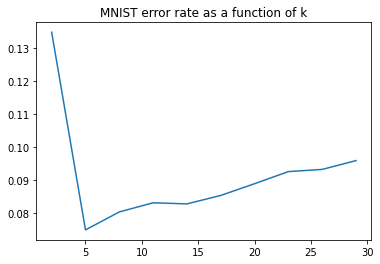

In [ ]:
p = 30

error_rates = []

for k in range(2, 30, 3):
  adj = get_adjacency_graph(MNIST_X[:total_samples], k)
  vecs = eigenfunctions(adj, p)
  A = build_classifier(vecs, labeled_MNIST_X, labeled_MNIST_y, num_classes, p)
  prediction = label_data(A, vecs, num_labeled)
  error_rate = np.sum(prediction != real_labels_MNIST) / prediction.shape[0]
  error_rates.append(error_rate)
  print(f'k={k}, error_rate={error_rate}')

plt.figure()
plt.plot(range(2, 30, 3), error_rates)
plt.title('MNIST error rate as a function of k')

best_k = np.argmin(error_rates) + 1
best_error_rate = np.min(error_rates)
print(f'Best performing k value: {best_k} with error rate of {best_error_rate * 100}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


k=30, error_rate=0.09644444444444444
k=40, error_rate=0.10455555555555555
k=50, error_rate=0.1078888888888889


Text(0.5, 1.0, 'MNIST error rate as a function of k')

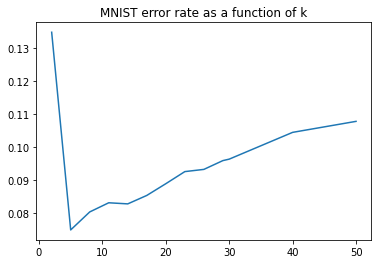

In [ ]:
for k in range(30, 60, 10):
  adj = get_adjacency_graph(MNIST_X[:total_samples], k)
  vecs = eigenfunctions(adj, p)
  A = build_classifier(vecs, labeled_MNIST_X, labeled_MNIST_y, num_classes, p)
  prediction = label_data(A, vecs, num_labeled)
  error_rate = np.sum(prediction != real_labels_MNIST) / prediction.shape[0]
  error_rates.append(error_rate)
  print(f'k={k}, error_rate={error_rate}')

plt.figure()
plt.plot(list(range(2, 30, 3)) +list(range(30, 60, 10)), error_rates)
plt.title('MNIST error rate as a function of k')

num_labeled=50
error_rate=0.8925628140703518
num_labeled=100
error_rate=0.20272727272727273
num_labeled=500
error_rate=0.07631578947368421
num_labeled=1000
error_rate=0.07477777777777778
num_labeled=5000
error_rate=0.0656


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


Text(0.5, 1.0, 'MNIST error rate as a function of number of points labeled')

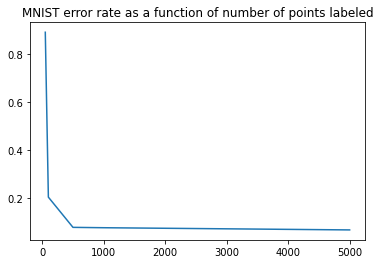

In [ ]:
k = 8
p = 50

error_rates = []
num_labeled_range = [50, 100, 500, 1000, 5000]

adj = get_adjacency_graph(MNIST_X[:total_samples], k)
vecs = eigenfunctions(adj, p)


for num_labeled in num_labeled_range:
  print(f'num_labeled={num_labeled}')
  labeled_MNIST_X = MNIST_X[:num_labeled]
  labeled_MNIST_y = MNIST_Labels[:num_labeled].astype(int)
  unlabeled_MNIST_X = MNIST_X[num_labeled:total_samples] # not used
  real_labels_MNIST = MNIST_Labels[num_labeled:total_samples].astype(int)
  
  A = build_classifier(vecs[:, :p], labeled_MNIST_X, labeled_MNIST_y, num_classes, p)
  prediction = label_data(A, vecs[:, :p], num_labeled)
  error_rate = np.sum(prediction != real_labels_MNIST) / prediction.shape[0]
  error_rates.append(error_rate)
  print(f'error_rate={error_rate}')

plt.figure()
plt.plot(num_labeled_range, error_rates)
plt.title('MNIST error rate as a function of number of points labeled')

Text(0.5, 1.0, 'MNIST error rate as a function of number of points labeled')

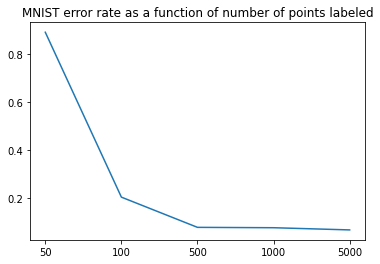

In [ ]:
plt.plot(['50', '100', '500', '1000', '5000'], error_rates)

plt.title('MNIST error rate as a function of number of points labeled')

## Olivetti Face Experiment

From scikit-learn's website, "This dataset contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge." There are 40 classes with 400 samples total. Each sample is a $64*64=4096$ image. Clearly, this problem is significantly more difficult due to the smaller dataset along with higher dimensionality. As a result, we first try using half the number of available samples to see how well the manifold learning process works. 

Remember that chose k=4 since every person only had 5 photos. when k was 8, we were getting neighbors that were not the same label :O --> intraclass dependency wtf its called

200 labeled, p ~= 64, k =8 had error rate 24.5 percent

200 labeled, p = 96, k = 4 had error rate 15 percent

300 labeled, p = 79, k = 4 had error rate 12 percent

350 labeled, p = 91, k = 6 had error rate 14 percent

350 labeled, p = 91, k = 3 had error rate 8 percent

350 labeled, p = 187, k = 2 had error rate 8 percent

150 labeled, p = 37, k = 3, had error rate 36.8 percent

150 labeled, p = 50, k = 2, had error rate 45.6 percent

In [ ]:
num_labeled = 350
num_classes = 40
total_samples = 400
k = 3
labeled_Faces_X = FacesX[:num_labeled]
labeled_Faces_y = FacesLabels[:num_labeled].astype(int)
unlabeled_Faces_X = FacesX[num_labeled:] # not used
real_labels_Faces = FacesLabels[num_labeled:].astype(int)

### Face Examples

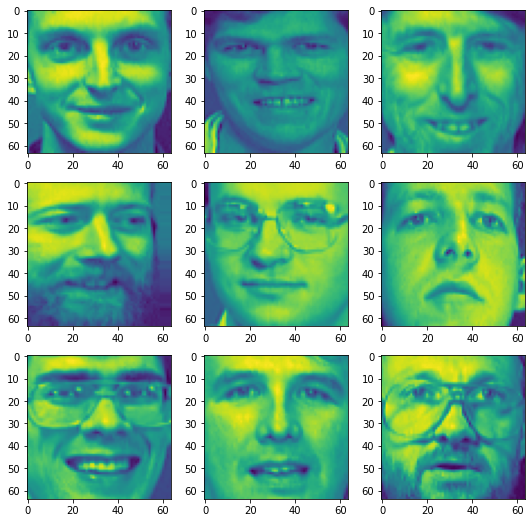

In [ ]:
import random
from google.colab import files
ax = []
fig = plt.figure(figsize=(9,9))
sample = random.randint(0, 390)
j = 0
for i in range(sample, sample + 9):
    img = FacesX[i].reshape(64,64)
    ax.append(fig.add_subplot(3,3,j+1))
    plt.imshow(img)
    j += 1
# plt.savefig("olivetti_faces.png")
# files.download("olivetti_faces.png") 
plt.show()

In [ ]:
largest_p_value = 398
error_rates = []
# Build adjacency graph for the data using all available samples
adj = get_adjacency_graph(FacesX, k)
# Solve for all possible eigenvectors 
vecs = eigenfunctions(adj, largest_p_value)
# Iterate through possible choices of p and select best performing
for p in range(1, largest_p_value + 1):
    A = build_classifier(vecs[:, :p], labeled_Faces_X, labeled_Faces_y, num_classes, p)
    prediction = label_data(A, vecs[:, :p], num_labeled)
    error_rate = np.sum(prediction != real_labels_Faces) / prediction.shape[0]
    error_rates.append(error_rate)
    if (p % 50 == 0):
        print(f'p={p}, error_rate={error_rate}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


p=50, error_rate=0.28
p=100, error_rate=0.18
p=150, error_rate=0.2
p=200, error_rate=0.18
p=250, error_rate=0.4
p=300, error_rate=0.98
p=350, error_rate=0.96


Best performing p value: 91 with error rate of 16.0


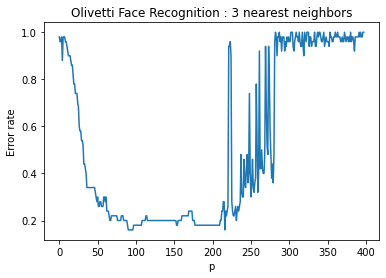

In [ ]:
plt.figure()
plt.plot(error_rates)
plt.title('Olivetti Face Recognition : 3 nearest neighbors')
plt.xlabel('p')
plt.ylabel('Error rate')
plt.savefig("olivetti_faces_performance.png")
files.download("olivetti_faces_performance.png") 

best_p = np.argmin(error_rates) + 1
best_error_rate = np.min(error_rates)
print(f'Best performing p value: {best_p} with error rate of {best_error_rate * 100}')